# A character one hot based seq2seq neural network
## For using as spell-checker, grammar checker, etc.

The notebook is based on the Spell-checker project.

Data can be found as on Project Gutenberg or as cleaned wikipedia dumps. The neural net will learn, to repeat, that which is found in "./books" folder. The file, or files, will need to have one sentence per line.

To save time for multiple runs, file are saved in folder "./data" and weights of the neural network are saved and reused. Note that reusing only works for the same symbol set and neural net configuration. If you have varying symbols in different data sets (books), run all of them at the same time (put them all in the books folder), and use the offset variable to chew through all of the data piece by piece.

Results:

Different sizes of data (Kilo (1000) sentences)

<table>
<tr><td><td><td><td>Highest<td>scores<td>sentences (10-40)
<tr><td>Size<td>batch<td>tr_acc<td>val_acc<td>test_acc<td>dropout<td>
<tr><td>1000K<td>32<td>99.84<td>99.81<td>OOM**<td>0.1, 0.1, 0.1
<tr><td>1000K<td>1024<td>OOM**<td><td><td>0.1, 0.1, 0.1
<tr><td>800K<td>1024<td>99.91<td>99.79<td>OOM<td>0.1, 0.1, 0.1
<tr><td>600K<td>1024<td>99.93<td>99.77<td>99.77<td>0.1, 0.1, 0.1
<tr><td>400K<td>1024<td>99.90<td>99.71<td>99.72<td>0.1, 0.1, 0.1
<tr><td>200K<td>1024<td>99.91*<td>99.53<td>99.54<td>0.1, 0.1, 0.1
<tr>
<tr><td><td>     <td>      <td>       <td>        <td>*manually stopped
<tr><td><td>     <td>      <td>       <td>        <td>**Out Of Memory
</table> 
    
    
Different batch sizes
    
<table>
<tr><td><td><td><td>Highest<td>scores 100K sentences (10-40)<td>
<tr><td>batch<td>tr_acc<td>val_acc<td>test_acc<td>regularizers
<tr><td>2048<td>99.76<td>98.79<td>98.78<td>dropout 0.1, 0.1, 0.1
<tr><td>2048<td><td>98.64<td>98.62<td>kernel, bias, activity(only 1 of each)
<tr><td>1024<td>99.80<td>99.04<td>99.04<td>dropout 0.1, 0.1, 0.1
<tr><td>512<td><td>99.01<td>99.00<td>kernel, bias, activity(only 1 of each)
<tr><td>32<td>1.0000<td>99.31<td>99.31<td>kernel, bias, activity(only 1 of each)
</table> 

## Load libraries

In [1]:
import bz2
from   collections                import namedtuple
from   __future__                 import print_function
import numpy                      as     np
import os
from   os                         import listdir
from   os.path                    import isfile, join
import pandas                     as     pd
import matplotlib.pyplot          as     plt
import re
from   sklearn.model_selection    import train_test_split
import tensorflow                 as     tf
from   tensorflow                 import keras
from   tensorflow.keras           import regularizers
from   tensorflow.keras.callbacks import EarlyStopping
from   tensorflow.keras.layers    import (Activation, Bidirectional, Concatenate, Dense, 
                                         Input, LSTM)
from   tensorflow.keras.models    import Model
from   tensorflow.python.client   import device_lib
import time



2022-01-23 15:55:09.825137: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
batch_size  = 1024      # Limited by GPU memory. Larger is much faster, but uses more memory. Smaller usually gives better scores.
epochs      = 200     # Number of epochs to train for. Smaller data sets
                      # needs more runs than larger data sets. 1 is only
                      # useful for testing. Less is better, an overtrained model is useless.
input_dim   = 60      # time steps, ie number of letters

max_length  = 60       # was 92 # Limit the data we will use to train our model
min_length  = 10       # min/max on sentence lengths
units       = 64
output_size = 10
latent_dim  = 256       # Latent dimensionality of the encoding space.
num_samples = 100000    # Number of samples to train on. Used with the offset variable you can chew through
                        # large data sets, without using much memory.100000
threshold   = 0.95      # introduce 5 % errors, i.e. about once for every 20 chars.

path        = './books/' # Paths to subfolders
path_data   = './data/'

## Uncomment to check hardware. Please note that a GPU is needed if you want to run anything but the smallest datasets.

In [3]:
# uncomment if you have GPU problems
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
# uncomment to see what hardware you have
#print(device_lib.list_local_devices())

In [5]:
# For loading of books, encoding needs to be defined 
# for other os than linux.

def load_book(path):
    """Load a book from its file"""
    input_file = os.path.join(path)
    with open(input_file, encoding='utf-8') as f:
        book = f.read()
    return book

# For loading of precomputed data
def load_data(file, path):
    """Load data from its file"""
    loaded_data = []
    input_file = os.path.join(path, file)
    print (input_file)
    # Load and decompress data from file
    with bz2.open("./data/sentences.bz2", "rt") as f:
        loaded_data = f.read()
    return loaded_data

def load_vocab_input(file, path):
    """Load data from its file"""
    input_characters = set()
    input_file = os.path.join(path, file)
    # Load and decompress data from file
    with bz2.open("./data/vocab_input.bz2", "rt") as f:
        loaded_data = f.read()
    for char in loaded_data:
        input_characters.add(char)
    return input_characters

def load_vocab_target(file, path):
    """Load data from its file"""
    target_characters = set()
    input_file = os.path.join(path, file)
    # Load and decompress data from file
    with bz2.open("./data/vocab_target.bz2", "rt") as f:
        loaded_data = f.read()
    for char in loaded_data:
        target_characters.add(char)
    return target_characters

In [6]:
def make_trainingdata (inp_texts, targ_texts, text_offset, num_samples, 
                       max_encoder_seq_length, num_encoder_tokens, max_decoder_seq_length, num_decoder_tokens):
    enc_input_data = np.zeros(
        (num_samples, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    ) #len(input_texts)
    dec_input_data = np.zeros(
        (num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    ) # len(input_texts)
    dec_target_data = np.zeros(
        (num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    ) # len(input_texts)
    
    for i, (inp_text, targ_text) in enumerate(zip(inp_texts[0+text_offset:num_samples+text_offset], targ_texts[0+text_offset:num_samples+text_offset])):
        for t, char in enumerate(inp_text):
            enc_input_data[i, t, input_token_index[char]] = 1.0
        enc_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
        for t, char in enumerate(targ_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            dec_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                dec_target_data[i, t - 1, target_token_index[char]] = 1.0
        dec_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
        dec_target_data[i, t:, target_token_index[" "]] = 1.0
    return enc_input_data, dec_input_data, dec_target_data

In [7]:
# Global variables
# Check if data files exists
# Using try is a cheat. Properly done the code would check if flie exists.
try:
    loaded_data = load_data('sentences.bz2', path_data)
    sentences_exist = True
    print('Loaded sentences.')
    sentences = []
    for line in loaded_data.splitlines():
        sentences.append(line)
except:
    sentences_exist = False
    print('No sentences found to load. Going to load books.')
    
try:
    vocab_input = load_vocab_input('vocab_input.bz2', path_data)
    vocab_input_exists = True
    print('Loaded vocab_input.')
    vocab_target = load_vocab_target('vocab_target.bz2', path_data)
    print('Loaded vocab_target.')
    vocab_target_exists = True
except:
    vocab_target_exists = vocab_input_exists = False

./data/sentences.bz2
Loaded sentences.
Loaded vocab_input.
Loaded vocab_target.


## Define file loading functions

In [8]:
# Collect all of the book file names
if sentences_exist == False:
    book_files = [f for f in listdir(path) if isfile(join(path, f))]
    book_files = book_files[0:]

In [9]:
# Load the books using the file names
if sentences_exist == False:
    books = []
    for book in book_files:
        books.append(load_book(path+book))

In [10]:
# Compare the number of words in each book 
if sentences_exist == False:
    for i in range(len(books)):
        print("There are {} words in {}.".format(len(books[i].split()), book_files[i]))

In [11]:
# Check to ensure the text looks alright
if sentences_exist == False:
    print(books[0][:500],"/.../")

## Preparing the Data

In [12]:
def clean_text(text):
    '''Remove unwanted characters and extra spaces from the text'''
    #text = re.sub(r'\n', ' ', text) 
    text = re.sub(r'[{}@_*>()\\#%+=\[\]]','', text)
    text = re.sub('a0','', text)
    text = re.sub('\'92t','\'t', text)
    text = re.sub('\'92s','\'s', text)
    text = re.sub('\'92m','\'m', text)
    text = re.sub('\'92ll','\'ll', text)
    text = re.sub('\'91','', text)
    text = re.sub('\'92','', text)
    text = re.sub('\'93','', text)
    text = re.sub('\'94','', text)
    #text = re.sub('\.','. ', text)
    #text = re.sub('\!','! ', text)
    #text = re.sub('\?','? ', text)
    text = re.sub(' +',' ', text)
    #text = [text.islower()]
    return text

In [13]:
# Clean the text of the books
if sentences_exist == False:
    clean_books = []
    for book in books:
        clean_books.append(clean_text(book))

In [14]:
# Check to ensure the text has been cleaned properly
if sentences_exist == False:
    print(clean_books[0][:500],"/.../")

In [15]:
# Split the text from the books into sentences.
# Choose whether only lower case or not below.
if sentences_exist == False:
    sentences = []
    save_sentences = ""
    for book in clean_books:
        for sentence in book.splitlines():
            #sentence = sentence.lower() # lower case to halve the nr of symbols
            sentences.append(sentence)
            save_sentences += (sentence + '\n')
    print("There are {} sentences.".format(len(sentences)))
    # Write compressed data to file
    with bz2.open("./data/sentences.bz2", "wt") as bzip_file:
        unused = bzip_file.write(save_sentences)
        #unused = bzip_file.write(save_sentences.encode())     
        # encoding=’utf8′, errors=’strict’
    save_sentences = ""

In [16]:
# Check to ensure the text has been split correctly.
print(sentences[:5])

['I ändelser kan även u och o kvarstå.', 'Här säger man alltså skojin och sättjin.', 'Den har runt ansikte med runda ögon.', 'Kroppen är kort och kraftig.', 'Scottish fold är lugna och vänliga.']


In [17]:
# Find the length of each sentence
lengths = []
for sentence in sentences:
    lengths.append(len(sentence))
lengths = pd.DataFrame(lengths, columns=["counts"])

In [18]:
lengths.describe()

,counts
count,2.228165e+06
mean,3.364417e+01
std,4.520924e+00
min,1.000000e+01
25%,3.000000e+01
50%,3.400000e+01
75%,3.800000e+01
max,4.000000e+01


In [19]:
# Get the chosen length of sentences
good_sentences = []

for sentence in sentences:
    if len(sentence) <= max_length and len(sentence) >= min_length:
        good_sentences.append(sentence)

# Find the length of each sentence
lengths = []
for sentence in good_sentences:
    lengths.append(len(sentence))
lengths = pd.DataFrame(lengths, columns=["counts"])
print("We will use {} sentences to train and test our model.".format(len(good_sentences)))

We will use 2228165 sentences to train and test our model.


In [20]:
lengths.describe()

,counts
count,2.228165e+06
mean,3.364417e+01
std,4.520924e+00
min,1.000000e+01
25%,3.000000e+01
50%,3.400000e+01
75%,3.800000e+01
max,4.000000e+01


In [21]:
# Split the data into training and testing sentences (testing is for
# inferencing). There will be three data sets; training which is split
# into training and validation during fit, and testing for inferencing.
# Note that inferencing does not use the test set, as of yet.
training, testing = train_test_split(good_sentences, test_size = 0.1, random_state = 2)

print("Number of training sentences:", len(training))
print("Number of testing sentences: ", len(testing))

Number of training sentences: 2005348
Number of testing sentences:  222817


In [22]:
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
           'p','q','r','s','t','u','v','w','x','y','z','å','ä','ö',' ','.']

# Note that caps and numbers are not introduced as errors, because the data does not contain them.
#           'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',
#           'Q','R','S','T','U','V','X','Y','Z','Å','Ä','Ö',

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    noisy_sentence = ""
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence+=sentence[i]
        else:
            new_random = np.random.uniform(0,1,1)
            # ~20% chance characters will swap locations
            if new_random > 0.8:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence+=sentence[i+1]
                    noisy_sentence+=sentence[i]
                    i += 1
            # ~20% chance an extra letter will be added to the sentence
            elif new_random > 0.60:
                noisy_sentence+=sentence[i]
                noisy_sentence+=sentence[i]
                #random_letter = np.random.choice(letters, 1)[0]
                #noisy_sentence.append(vocab_to_int[random_letter])
            # ~40% chance a letter will be substituted for another
            elif new_random > 0.20:
                noisy_sentence+=sentence[i]
                #random_letter = np.random.choice(letters, 1)[0]
                #noisy_sentence.append(vocab_to_int[random_letter])
            # 20% chance a character will not be typed
            else:
                pass     
        i += 1
    return noisy_sentence

*Note: The noise_maker function is used to create spelling mistakes that are similar to those we would make. Sometimes we forget to type a letter, type a letter in the wrong location, or add an extra letter.*

In [23]:
# Check to ensure noise_maker is making mistakes correctly.

for sentence in training[:5]:
    print(sentence)
    print(noise_maker(sentence, threshold))
    print()

Lac Gatelier är en sjö i Kanada.
Lac Gtelier är en sj öi Kanada.

Medelhavsklimat råder i trakten.
Medelhavsklima råder i trakten.

Falls Brook är ett vattendrag i Kanada.
Falls Brok är ett vattendrag i Kanada.

Orijärvi är en sjö i Finland.
Orijärvi  är en sjö i Fnland.

Tejgaon är en ort i Bangladesh.
Tejgaon är en ort i Bangladesh.



# the Model data

## Initialize and save space

In [24]:
input_texts = []
target_texts = []

if vocab_target_exists:
    target_characters = vocab_target
    target_characters = sorted(list(target_characters))
else: 
    target_characters = set()

if vocab_input_exists:
    input_characters = vocab_input
    input_characters = sorted(list(input_characters))
else:
    input_characters = set()

lines = training
training = []
good_sentences = []
sentences = []

In [25]:
added_characters = False
# offset for large datasets, if you want to run it piece by piece
line_offset = 0

for line in lines[line_offset: min((num_samples+line_offset), len(lines) - 1)]:
    target_text = str (line)
    input_text = noise_maker(line, threshold)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            added_characters = True
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            added_characters = True

In [26]:
# Make test texts
test_x = []
test_y = []

# test texts, same vocab

for line in testing: #[line_offset: min((num_samples+line_offset), len(training) - 1)]:
    y = str (line)
    x = noise_maker(line, threshold)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    y = "\t" + y + "\n"
    test_x.append(x)
    test_y.append(y)
    for char in x:
        if char not in input_characters:
            input_characters.add(char)#append(char)#add(char)
            added_characters = True
    for char in y:
        if char not in target_characters:
            target_characters.add(char)#append(char)#add(char)
            added_characters = True

In [27]:
if not vocab_input_exists:
    print('saving vocab')
    input_characters = sorted(list(input_characters))
    vocab_input=""
    for char in input_characters:
        vocab_input += char
    with bz2.open("./data/vocab_input.bz2", "wt") as bzip_file:
        unused = bzip_file.write(vocab_input)
    added_characters = False

if not vocab_target_exists:
    print('saving vocab')
    target_characters = sorted(list(target_characters))
    vocab_target=""
    for char in target_characters:
        vocab_target += char
    with bz2.open("./data/vocab_target.bz2", "wt") as bzip_file:
        unused = bzip_file.write(vocab_target)
    added_characters = False

In [28]:
# Note that added characters (new characters in new datasets) are
# save correctly, but read incorrectly and then sorted. This is a bug.
# It is better to use a fixed vocabulary (list of symbols), that are 
# always guaranteed to remain in the same order, even when data 
# sets (texts/books), contain different characters/symbols.
if added_characters:
    vocab_input=""
    for char in input_characters:
        vocab_input += char
    with bz2.open("./data/vocab_input.bz2", "wt") as bzip_file:
        unused = bzip_file.write(vocab_input)
    vocab_target=""
    for char in target_characters:
        vocab_target += char
    with bz2.open("./data/vocab_target.bz2", "wt") as bzip_file:
        unused = bzip_file.write(target_characters)

In [29]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max_length + 11 # max([len(txt) for txt in clean_books])
max_decoder_seq_length = max_encoder_seq_length + 2 # max([len(txt) for txt in target_texts])

print("Number of samples:", len(lines))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 2005348
Number of unique input tokens: 62
Number of unique output tokens: 64
Max sequence length for inputs: 71
Max sequence length for outputs: 73


In [30]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print(input_token_index)
print(target_token_index)

# One hot
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

{' ': 0, '!': 1, '.': 2, '?': 3, 'A': 4, 'B': 5, 'C': 6, 'D': 7, 'E': 8, 'F': 9, 'G': 10, 'H': 11, 'I': 12, 'J': 13, 'K': 14, 'L': 15, 'M': 16, 'N': 17, 'O': 18, 'P': 19, 'Q': 20, 'R': 21, 'S': 22, 'T': 23, 'U': 24, 'V': 25, 'W': 26, 'X': 27, 'Y': 28, 'Z': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55, 'Ä': 56, 'Å': 57, 'Ö': 58, 'ä': 59, 'å': 60, 'ö': 61}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '.': 4, '?': 5, 'A': 6, 'B': 7, 'C': 8, 'D': 9, 'E': 10, 'F': 11, 'G': 12, 'H': 13, 'I': 14, 'J': 15, 'K': 16, 'L': 17, 'M': 18, 'N': 19, 'O': 20, 'P': 21, 'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'W': 28, 'X': 29, 'Y': 30, 'Z': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50,

In [31]:
# One hot
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

# Build the RNN model

In [44]:
# Functional model 
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_1 = Bidirectional(LSTM(latent_dim, return_sequences=True, 
                               dropout=0.1, 
                               #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                               #bias_regularizer=regularizers.l2(1e-4), 
                               #activity_regularizer=regularizers.l2(1e-5)
                               ))(encoder_inputs)
encoder_2 = Bidirectional(LSTM(latent_dim, return_sequences=True, 
                               dropout=0.1, 
                               #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                               #bias_regularizer=regularizers.l2(1e-4), 
                               #activity_regularizer=regularizers.l2(1e-5)
                               ))(encoder_1)
encoder_3 = Bidirectional(LSTM(latent_dim, return_state=True, 
                               dropout=0.1,
                               #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                               #bias_regularizer=regularizers.l2(1e-4),
                               #activity_regularizer=regularizers.l2(1e-5)
                               ))
encoder_outputs, forward_h, forward_c, backward_h, backward_c  = encoder_3(encoder_2)
state_h = Concatenate()([forward_h, backward_h]) #Average()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c]) #Average()([forward_c, backward_c])

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)  # *2 because of concat on Bidirectional
decoder_output, final_memory_state, final_carry_state  = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax") 
decoder_outputs = decoder_dense(decoder_output)

In [33]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 62)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 512)    653312      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 512)    1574912     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 512), (None, 1574912     bidirectional_1[0][0]            
______________________________________________________________________________________________

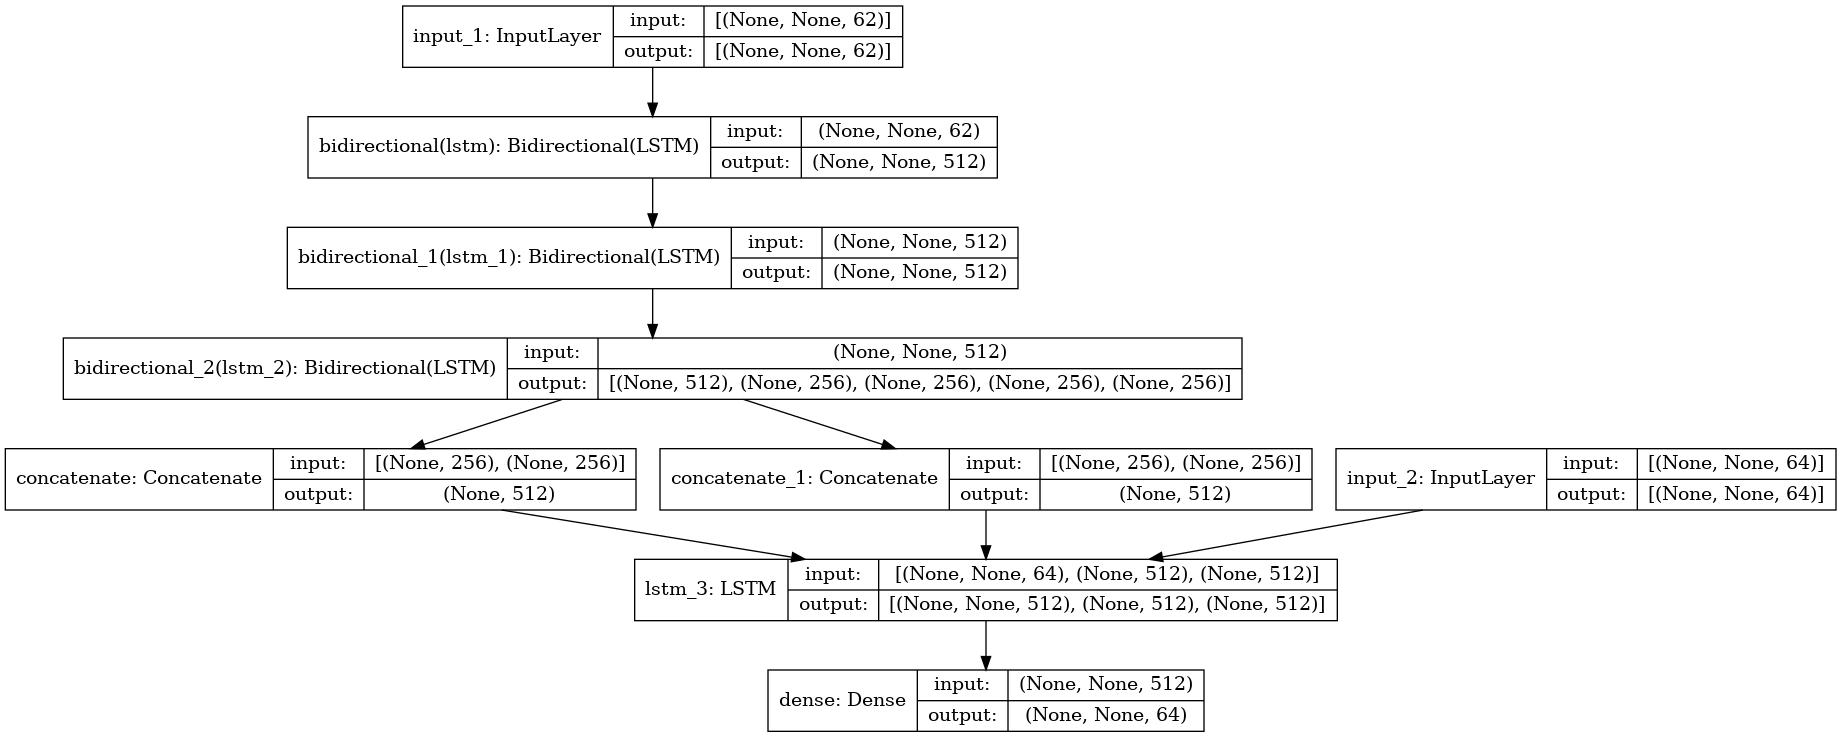

In [34]:
# Let us see the model in graphical form
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

## Training the Model

In [35]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy']) 
# Alternatives: rmsprop, Adam (bad), Nadam (not good on multilayer)

In [36]:
callback_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)

In [37]:
# Do not run this line if no weights are saved!
#status = model.load_weights('weights') 

In [38]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callback_stopping, lr_scheduler],
    validation_split=0.2)

2022-01-23 15:56:21.235473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-23 15:56:21.254380: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2999675000 Hz


Epoch 1/500


2022-01-23 15:56:27.199511: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-23 15:56:27.650729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-01-23 15:56:27.890869: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-23 15:56:28.437647: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-01-23 15:56:28.437718: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


79/79 [==============================] - 22s 183ms/step - loss: 1.7295 - accuracy: 0.5756 - val_loss: 1.4013 - val_accuracy: 0.6184
Epoch 2/500
79/79 [==============================] - 14s 172ms/step - loss: 1.2179 - accuracy: 0.6724 - val_loss: 1.0194 - val_accuracy: 0.7275
Epoch 3/500
79/79 [==============================] - 13s 166ms/step - loss: 0.9052 - accuracy: 0.7607 - val_loss: 0.7654 - val_accuracy: 0.8020
Epoch 4/500
79/79 [==============================] - 13s 169ms/step - loss: 0.6985 - accuracy: 0.8181 - val_loss: 0.6143 - val_accuracy: 0.8425
Epoch 5/500
79/79 [==============================] - 13s 162ms/step - loss: 0.5652 - accuracy: 0.8538 - val_loss: 0.4961 - val_accuracy: 0.8703
Epoch 6/500
79/79 [==============================] - 14s 172ms/step - loss: 0.4804 - accuracy: 0.8732 - val_loss: 0.4610 - val_accuracy: 0.8787
Epoch 7/500
79/79 [==============================] - 13s 163ms/step - loss: 0.4259 - accuracy: 0.8853 - val_loss: 0.4055 - val_accuracy: 0.8900
Epoc

79/79 [==============================] - 13s 167ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0367 - val_accuracy: 0.9902
Epoch 58/500
79/79 [==============================] - 13s 170ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0368 - val_accuracy: 0.9903
Epoch 59/500
79/79 [==============================] - 13s 167ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.0371 - val_accuracy: 0.9902
Epoch 60/500
79/79 [==============================] - 13s 166ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.0371 - val_accuracy: 0.9901
Epoch 61/500
79/79 [==============================] - 13s 167ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.0363 - val_accuracy: 0.9904
Epoch 62/500
79/79 [==============================] - 13s 165ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.0366 - val_accuracy: 0.9904
Epoch 63/500
79/79 [==============================] - 13s 165ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.0367 - val_accuracy: 0.990

In [39]:
# Save weights
model.save_weights('weights')

All scores


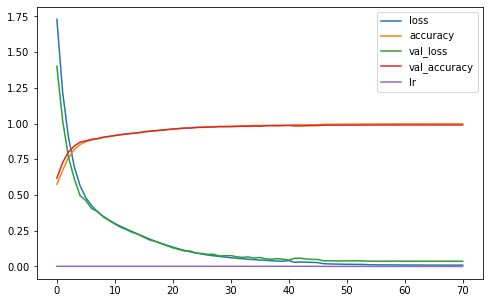

Only accuracy scores


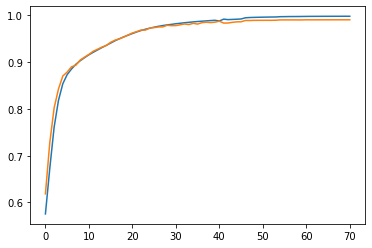

Only loss scores


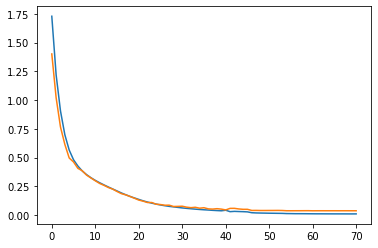

Learning rate


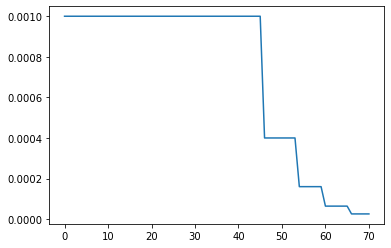

In [40]:
# Evaluate model
print("All scores")
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

print("Only accuracy scores")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.show()

print("Only loss scores")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_los')
plt.show()

print("Learning rate")
plt.plot(history.history['lr'], label='learning_rate')
plt.show()

In [41]:
x_test1, x_test2, y_test = make_trainingdata(test_x, 
                           test_y, 0, len(test_x)-1,
                           max_encoder_seq_length, num_encoder_tokens, max_decoder_seq_length, num_decoder_tokens) 

score = model.evaluate([x_test1, x_test2], y_test)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

6963/6963 [==============================] - 132s 19ms/step - loss: 0.0362 - accuracy: 0.9904
Test loss: 0.03622233122587204
Test accuracy: 0.9903622269630432


## Fixing Custom Sentences

In [42]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,)) # *2 because of concat on Bidirectional
decoder_state_input_c = Input(shape=(latent_dim*2,)) # *2 because of concat on Bidirectional
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_output, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_output)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

print("From training set:")
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input   sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

From training set:
-
Input   sentence: Lac Gatelier är en sjö i Kanada.
Decoded sentence: Lac Gatelier är en sjö i Kanada.

-
Input   sentence: Medelhavsklimat råder i trakten.
Decoded sentence: Medelhavsklimat råder i trakten.

-
Input   sentence: Falls Brook är ett vattendrag i Kanada.
Decoded sentence: Falls Brook är ett vattendrag i Kanada.

-
Input   sentence: Orijärvi är en sjö i Finland.
Decoded sentence: Orijärvi är en sjö i Finland.

-
Input   sentence: Tejgaon är en ort i Bangladesh.
Decoded sentence: Tejgaon är en ort i Bangladesh.

-
Input   sentence: Medelhavsklimat råder i trakten.
Decoded sentence: Medelhavsklimat råder i trakten.

-
Input   sentence: Inga underarter fins listade.
Decoded sentence: Inga underarter finns listade.

-
Input   sentence: Mahli Mnor är en kanali Indien.
Decoded sentence: Mahli Minor är en kanal i Indien.

-
Input   sentence: I trakten råder ett hett ökenkilmat.
Decoded sentence: I trakten råder ett hett ökenklimat.

-
Input   sentence: Cerro B

In [43]:
print()
print("From test set:")
for seq_index in range(20):
    # Take one sequence (part of the test set)
    # for trying out decoding.
    input_seq = x_test1[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input   sentence:', test_x[seq_index])
    print('Decoded sentence:', decoded_sentence)
    


From test set:
-
Input   sentence: Klimtförhållandean i områdt är arida.
Decoded sentence: Klimatförhållandena i området är arida.

-
Input   sentence: På den tiden bodde han i Genua.
Decoded sentence: På den tiden boden ha i Genau.

-
Input   sentence: Terrängen på Otok Olib  är platt.
Decoded sentence: Terrängen på Okot Olibi är platt.

-
Input   sentence: Elit eHockey Prospects.
Decoded sentence: Elit Hecocker Porscet.

-
Input   sentence: Arten är reproducerande i Sverige.
Decoded sentence: Arten är reproducerande i Sverige.

-
Input   sentence: Klimatet i området är tempererat.
Decoded sentence: Klimatet i området är tempererat.

-
Input   sentence: Inlanndsklimat råder i  trakten.
Decoded sentence: Inlandsklimat råder i trakten.

-
Input   sentence: Punta Tasbapauni är  en udde i Honduras.
Decoded sentence: Punta Tasbapanui är en udde i Honduras.

-
Input   sentence: Geografiskt ligger örana i Melanesien.
Decoded sentence: Geografiskt ligger öarna i Melanesien.

-
Input   senten